In [101]:
import argparse
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import wandb
import yaml
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm

from data_proc.emotionmocap_dataset import EmotionDataset
from data_proc.utils import increment_path
from model.model import TCN, PURE3D
import torch.nn.functional as F
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from CAM.eigen_cam import EigenCAM

from CAM.guided_backprop import GuidedBackpropReLUModel
from CAM.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from CAM.utils.model_targets import ClassifierOutputTarget


device = torch.device("cpu")
parser = argparse.ArgumentParser()
project='runs/train'
weight='latest'
exp_name='exp150'
data_path='/home/taehyun/workspace/childtoy/MotionReasoning/dataset/mocap_emotion_rig'
window=80
batch_size=30

processed_data_dir='processed_data_mocam/'

save_dir = Path(os.path.join('runs', 'train', exp_name))
wdir = save_dir / 'weights'
weights = os.listdir(wdir)

if weight == 'latest':
    weights_paths = [wdir / weight for weight in weights]
    weight_path = max(weights_paths , key = os.path.getctime)
else:
    weight_path = wdir / ('train-' + weight + '.pt')
ckpt = torch.load(weight_path, map_location=device)
print(f"Loaded weight: {weight_path}")


# Load LAFAN Dataset
Path(processed_data_dir).mkdir(parents=True, exist_ok=True)
emotion_dataset = EmotionDataset(data_dir=data_path, processed_data_dir=processed_data_dir, train=False, device=device, window=window)
emotion_data_loader = DataLoader(emotion_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
n_classes = 7
input_channels = 3
n_hid = 70
n_level = 4
n_channels = 64
channel_sizes = [n_hid] * n_level
kernel_size = 5
model = PURE3D(input_channels, n_channels, n_classes, kernel_size=kernel_size, dropout=0)
model.load_state_dict(ckpt['TCN'])
model.eval()
correct = 0
n_classes = ckpt['n_classes']
input_channels = ckpt['input_channels']
n_hid = ckpt['n_hid']
n_level = ckpt['n_level']
origin_data = iter(emotion_data_loader).next()# confusion_matrix = torch.zeros(7, 7)
local_q = origin_data["local_q"].to(device)
q_vel = origin_data["q_vel"].to(device) 
q_acc = origin_data["q_acc"].to(device) 
labels = origin_data["labels"].to(device)
data = torch.cat([local_q, q_vel, q_acc], axis=2)
data = torch.cat([local_q.unsqueeze(3), local_q.unsqueeze(3), local_q.unsqueeze(3)], axis=3)
data = data.permute(0,3,2,1)
output = model(data)


# 

Loaded weight: runs/train/exp150/weights/train-200.pt


In [31]:
 model.net.net3[4].weight.shape

torch.Size([256, 256, 5, 5])

In [26]:
labels

tensor([0])

In [17]:
cam = EigenCAM(model,
               model.net.net3, 
               use_cuda=torch.cuda.is_available())

# grayscale_cam = cam(input_tensor, targets=targets)
# # Take the first image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# # And lets draw the boxes again:
# image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
# Image.fromarray(image_with_bounding_boxes)

In [62]:
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple
from CAM.activations_and_gradients import ActivationsAndGradients
from CAM.utils.svd_on_activations import get_2d_projection
from CAM.utils.image import scale_cam_image
from CAM.utils.model_targets import ClassifierOutputTarget


class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        print(len(cam_per_layer))
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)
        
        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

In [63]:

class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(EigenCAM, self).__init__(model, target_layers, use_cuda,
                                       reshape_transform)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return get_2d_projection(activations)



In [102]:
cam = EigenCAM(model,
               model.net.net3, 
               use_cuda=torch.cuda.is_available())

# grayscale_cam = cam(input_tensor, targets=targets)
# # Take the first image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# # And lets draw the boxes again:
# image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
# Image.fromarray(image_with_bounding_boxes)

In [103]:
grayscale_cam = cam(data, targets=None)


(array([[35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  

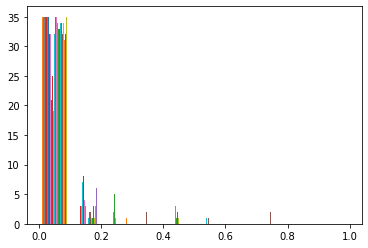

In [100]:
plt.hist(grayscale_cam[0])

0


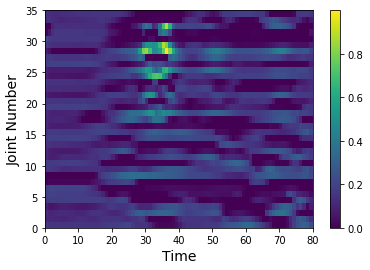

1


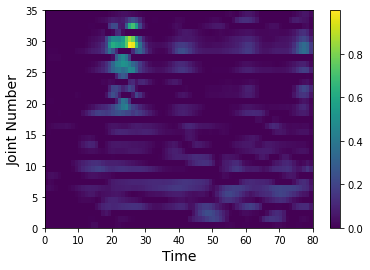

2


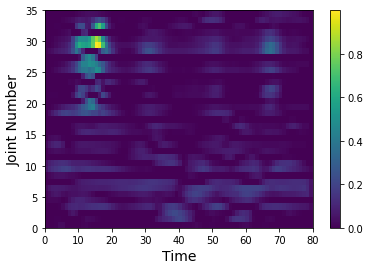

3


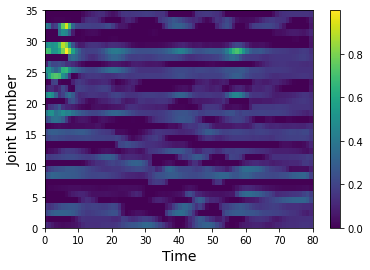

4


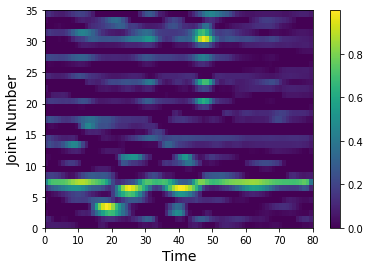

5


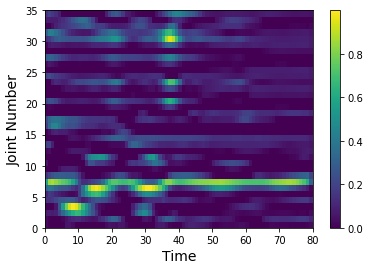

6


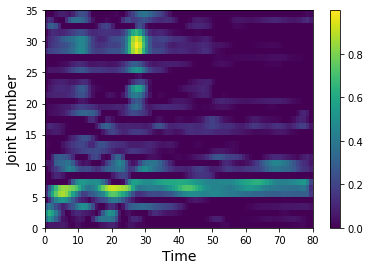

7


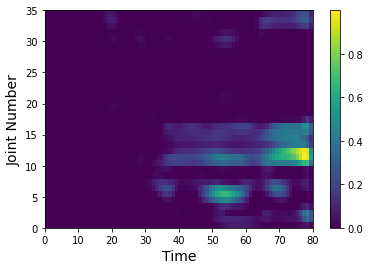

8


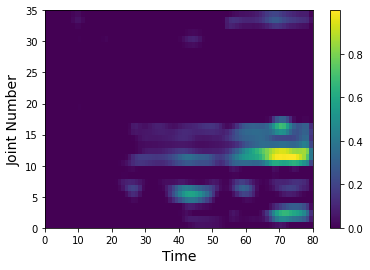

9


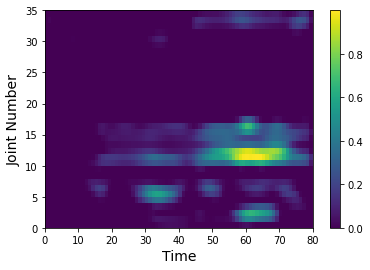

10


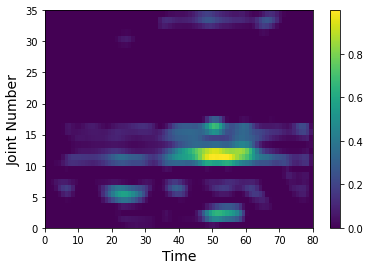

11


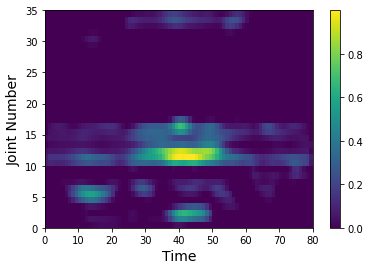

12


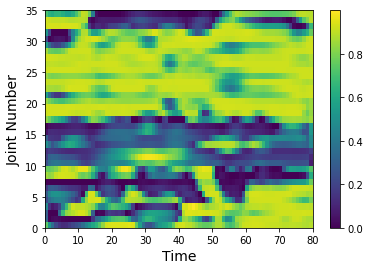

13


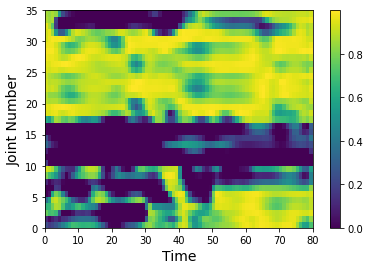

14


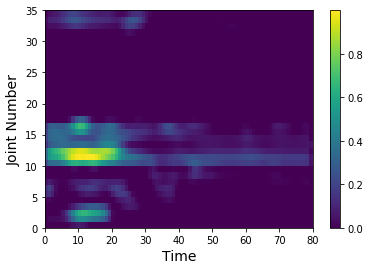

15


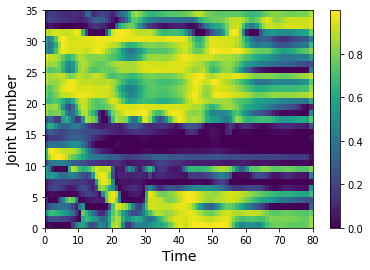

16


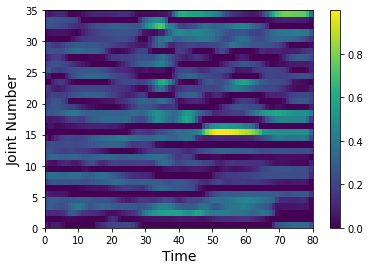

17


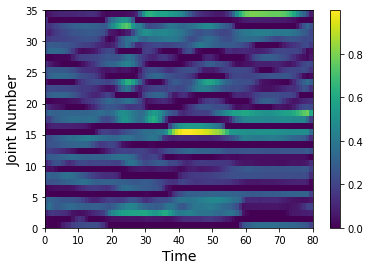

18


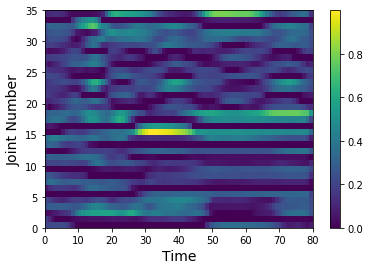

19


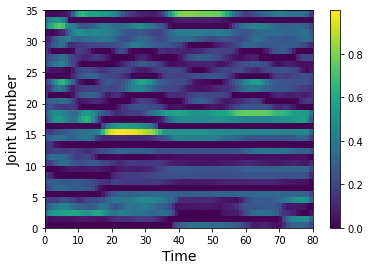

20


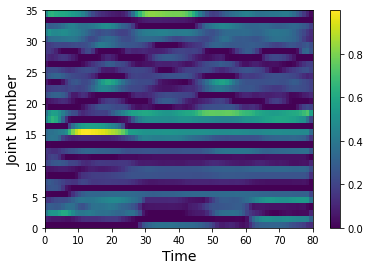

21


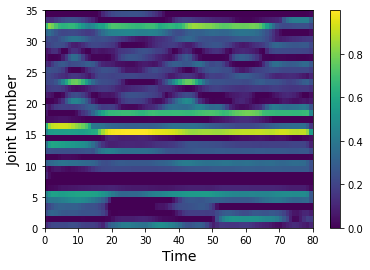

22


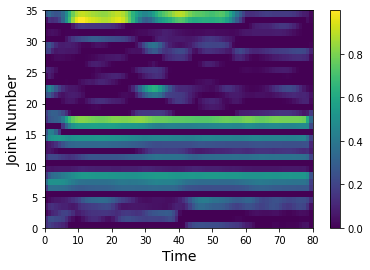

23


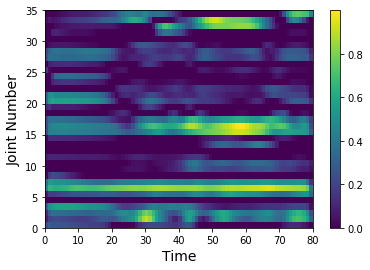

24


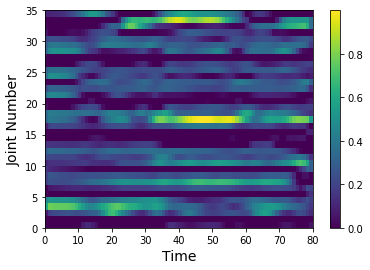

25


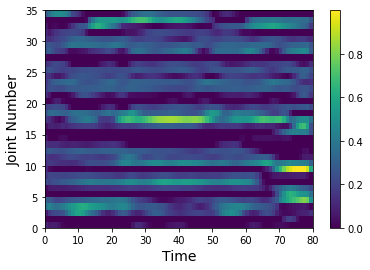

26


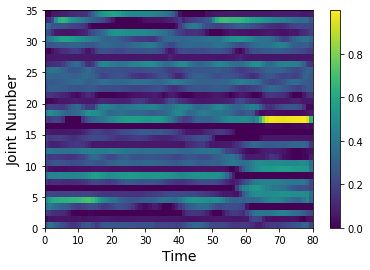

27


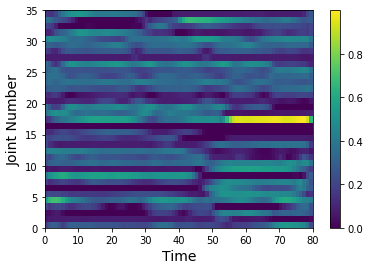

28


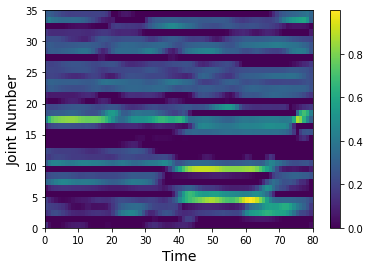

29


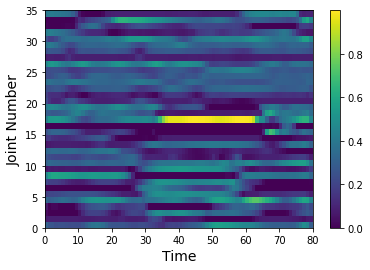

In [104]:
import matplotlib.pyplot as plt
for i in range(30):
    print(i)
    plt.pcolor(grayscale_cam[i,:])
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Joint Number', fontsize=14)
    plt.colorbar()    
    plt.show()

In [99]:
print(list(range(30)))
print(output.data.max(1)[1])
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
tensor([3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 5])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


In [68]:
model.net.net3

Sequential(
  (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=valid)
  (5): ReLU()
)

In [37]:
grayscale_cam.shape

(1, 35, 80)

In [51]:
grayscale_cam = cam(data, targets=None)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(data, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [21]:
grayscale_cam.shape

(35, 80)

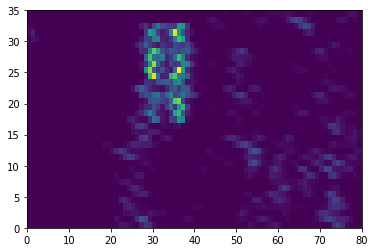

In [24]:
import matplotlib.pyplot as plt
plt.pcolor(grayscale_cam)

In [7]:
cam = EigenCAM(model=model, target_layers = model.net.net3, use_cuda=False)


In [9]:
iter(emotion_data_loader.next())

AttributeError: 'DataLoader' object has no attribute 'next'

In [14]:
with cam :
    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 1
    grayscale_cam = cam(input_tensor=data,
                        targets=None,
                        aug_smooth=False,
                        eigen_smooth=True)
    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument(
        '--image-path',
        type=str,
        default='./examples/both.png',
        help='Input image path')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')
    parser.add_argument('--method', type=str, default='gradcam',
                        choices=['gradcam', 'gradcam++',
                                 'scorecam', 'xgradcam',
                                 'ablationcam', 'eigencam',
                                 'eigengradcam', 'layercam', 'fullgrad'],
                        help='Can be gradcam/gradcam++/scorecam/xgradcam'
                             '/ablationcam/eigencam/eigengradcam/layercam')

    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    return args


if __name__ == '__main__':
    """ python cam.py -image-path <path_to_image>
    Example usage of loading an image, and computing:
        1. CAM
        2. Guided Back Propagation
        3. Combining both
    """

    args = get_args()
    methods = 
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    model = models.resnet50(pretrained=True)

    # Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
    target_layers = [model.layer4]

    rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])


    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
    
    targets = None

    # Using the with statement ensures the context is freed, and you can
    # recreate different CAM objects in a loop.
    cam = EigenCAM(model=model, )
    cam_algorithm = methods[args.method]
    with cam_algorithm(model=model,
                       target_layers=target_layers,
                       use_cuda=args.use_cuda) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=args.aug_smooth,
                            eigen_smooth=args.eigen_smooth)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=args.use_cuda)
    gb = gb_model(input_tensor, target_category=None)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    cv2.imwrite(f'{args.method}_cam.jpg', cam_image)
    cv2.imwrite(f'{args.method}_gb.jpg', gb)
    cv2.imwrite(f'{args.method}_cam_gb.jpg', cam_gb)